<a href="https://colab.research.google.com/github/Schify/FacExcerciseBook/blob/andras/DL_Get_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#A libary that will help us plot the neural network so we can better visualize it
!pip install -q pydot
!apt install graphviz
!pip install keras-tuner

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [23]:
#!rm -rf output

In [3]:
#loading all the necessary libraries for the project
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from tqdm.notebook import tqdm #useful module for progress bars
import logging
import gc
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
from datetime import datetime
!pip install keras_facenet
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
from keras_facenet import FaceNet
import shutil
from keras.utils.vis_utils import plot_model
from kerastuner.tuners import Hyperband
embedder = FaceNet()
OHEC =OneHotEncoder()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [4]:
import keras_tuner as kt
from tensorflow import keras

In [5]:
!unzip -q gdrive/MyDrive/DL_big_homework/fairface.zip -d /content

replace /content/train/1346.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
#reading the csv file that contains the labels with pandas
train_label_raw = pd.read_csv("gdrive/MyDrive/DL_big_homework/train.csv")
val_label_raw = pd.read_csv("gdrive/MyDrive/DL_big_homework/val.csv")

In [7]:
#displaying the training labels
train_label_raw.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [8]:
#dispalying the validation labels
val_label_raw.head()

,file,age,gender,race,service_test
0,val/1.jpg,3-9,Male,East Asian,False
1,val/2.jpg,50-59,Female,East Asian,True
2,val/3.jpg,30-39,Male,White,True
3,val/4.jpg,20-29,Female,Latino_Hispanic,True
4,val/5.jpg,20-29,Male,Southeast Asian,False


In [9]:
#Here we used sklearn in order to onehotencode our data thus preparing it for the CNN network
OHEC =OneHotEncoder()
"""
OHEC.fit(X=[["0-2", "Male", "Black", "False"],["3-9", "Female", "Indian", "True"],
["10-19", "Male", "East Asian", "False"],["20-29", "Male", "Southeast Asian", "False"],
["30-39", "Male", "Latino_Hispanic", "False"],["40-49", "Male", "Middle Eastern", "False"],["50-59", "Male", "White", "False"],
["60-69", "Male", "Middel Eastern", "False"],["more than 70", "Male", "White", "False"]])
"""
#The one hot encoder arranges the inputs in alphabetic order
OHEC.fit(val_label_raw[["age", "gender", "race", "service_test"]])
val_label = OHEC.transform(val_label_raw[["age", "gender", "race", "service_test"]]).toarray()
train_label = OHEC.transform(train_label_raw[["age", "gender", "race", "service_test"]]).toarray()
#We are putting thes together inside this npz dataformat
np.savez("labels.npz", train=train_label, val=val_label)

In [10]:
#loading the labels from the drive
labels=np.load("labels.npz")

In [11]:
#loading the embeddings from the drive
train_embeddings = np.load("gdrive/MyDrive/DL_big_homework/train_embedding2.npz")["train"]
train_labels = np.load("gdrive/MyDrive/DL_big_homework/labels.npz")["train"][0:train_embeddings.shape[0]]
print(train_labels.shape)

(13011, 20)


In [12]:
valid_embeddings = np.load("gdrive/MyDrive/DL_big_homework/val_embedding.npz")["val"]
valid_labels = np.load("gdrive/MyDrive/DL_big_homework/labels.npz")["val"][0:valid_embeddings.shape[0]]
print(valid_labels.shape)

(547, 20)


In [13]:
test_embeddings = np.load("gdrive/MyDrive/DL_big_homework/test_embedding.npz")["val"]
test_labels = np.load("gdrive/MyDrive/DL_big_homework/labels.npz")["val"][0:test_embeddings.shape[0]]
print(test_labels.shape)

(54, 20)


In [24]:
class MulticatLoss(keras.losses.Loss):
        def __init__(self):
            super(MulticatLoss, self).__init__()
            self.cce = keras.losses.CategoricalCrossentropy()

        def call(self, y_true, y_pred):
            return self.cce(y_true[...,0:9], y_pred[...,0:9])+\
                   self.cce(y_true[...,9:11],y_pred[...,9:11])+\
                   self.cce(y_true[...,11:18],y_pred[...,11:18])+\
                   self.cce(y_true[...,18:20], y_pred[...,18:20])

In [25]:
class MulticatMetric(tf.keras.metrics.Metric):

  def __init__(self, name='category_accuracy', **kwargs):
    super(MulticatMetric, self).__init__(name=name, **kwargs)
    self.accs = [tf.keras.metrics.CategoricalAccuracy() for i in range(4)]
    self.results = 0
    self.limits = [0,9,11,18,20]

  def update_state(self, y_true, y_pred, sample_weight=None):
    for i, acc in enumerate(self.accs): #this is not optimal
      acc.reset_state()
      acc.update_state(y_true[...,self.limits[i]:self.limits[i+1]], y_pred[...,self.limits[i]:self.limits[i+1]])

  def result(self):
    return self.accs[0].result()+\
           self.accs[1].result()+\
           self.accs[2].result()+\
           self.accs[3].result()

    #loops are bad unfortunately
outMetric = MulticatMetric(name="category_accuracy")

In [26]:
outMetric.update_state(np.array([[0,1,0,0,0,0,0,0,0, 1,0, 0,1,0,0,0,0,0, 0,1],
                        [0,1,0,0,0,0,0,0,0, 0,1, 0,0,1,0,0,0,0, 0,1]]),
                        np.array([[0,0.7,0.4,0,0,0,0,0,0, 0.7,0.6, 0.8,0.2,0,0,0,0,0, 1,0],
                         [0,0.7,0.4,0,0,0,0,0,0, 0.7,0.6, 0.8,0.2,0,0,0,0,0, 1,0]]))
tens1 = outMetric.result()
outMetric.update_state(np.array([[0,1,0,0,0,0,0,0,0, 1,0, 0,1,0,0,0,0,0, 0,1],
                        [0,0,1,0,0,0,0,0,0, 1,0, 0,0,1,0,0,0,0, 0,1]]),
                        np.array([[0,0.8,0.4,0,0,0,0,0,0, 0.7,0.6, 0.8,0.2,0,0,0,0,0, 1,0],
                         [0,0.7,0.8,0,0,0,0,0,0, 0.7,0.6, 0.8,0.2,0,0,0,0,0, 1,0]]))
tens2 = outMetric.result()
print(tens1)
print(tens2)
print(tens1+tens2)

tf.Tensor(1.5, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(3.5, shape=(), dtype=float32)


In [28]:


callback = tf.keras.callbacks.EarlyStopping(monitor='val_category_accuracy', patience=20)
#creating the neural network
def build_model(hp):
  inputs = keras.Input(shape=(train_embeddings.shape[1],))
  

  hp_activation=hp.Choice('activation', values=["relu","sigmoid"])
  x = keras.layers.Dense(units=hp.Int('units1', min_value=32, max_value=512, step=16), activation=hp.Choice('activation', values=["relu","sigmoid"]))(inputs)
  dp_rate=0.1+hp.Choice('rate1', values=[0.1,0.3,0.4])
  dp_rate2=0.1+hp.Choice('rate2', values=[0.1,0.3,0.4])
  x = keras.layers.Dropout(rate=dp_rate)(x)

  x = keras.layers.Dense(units=hp.Int('units2', min_value=32, max_value=512, step=16), activation=hp.Choice('activation', values=["relu","sigmoid"]))(x)
  x = keras.layers.Dropout(rate=dp_rate2)(x)

  x = keras.layers.Dense(units=hp.Int('units3', min_value=32, max_value=512, step=16), activation=hp.Choice('activation', values=["relu","sigmoid"]),)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dense(units=hp.Int('units4', min_value=32, max_value=512, step=16), activation=hp.Choice('activation', values=["relu","sigmoid"]),)(x)
  x = keras.layers.BatchNormalization()(x)
  #each category needs to have its own softmax activation layer 
  xs = [keras.layers.Dense(values.shape[0], activation="softmax")(x) for values in OHEC.categories_]#separate categories
  outputs = tf.keras.layers.Concatenate()(xs)

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model = keras.Model(inputs = inputs, outputs = outputs, name="OpenFace_extension")
  model.compile(
    loss=MulticatLoss(),#every bit needs to converge, maybe weighting is also needed
    optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
    metrics=[outMetric,"binary_accuracy"])#every bit has to be looked at separately
  return model



In [29]:


tuner = Hyperband(
    build_model,
    kt.Objective("val_category_accuracy", direction="max"),
    factor=10,
    max_epochs=100,
    directory='output',
    project_name='big_homework')

In [30]:
#printing the searching space
tuner.search_space_summary()

Search space summary
Default search space size: 8
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
rate1 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.3, 0.4], 'ordered': True}
rate2 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.3, 0.4], 'ordered': True}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
units4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [31]:
tuner.search(train_embeddings,train_labels, validation_split=0.1 ,batch_size = 32,epochs=100, callbacks=[callback])

Trial 131 Complete [00h 02m 09s]
val_category_accuracy: 1.6818182468414307

Best val_category_accuracy So Far: 2.0
Total elapsed time: 00h 43m 01s
INFO:tensorflow:Oracle triggered exit


In [32]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "OpenFace_extension"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 288)          147744      ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 288)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 128)          36992       ['dropout[0][0]']                
                                                                                 

In [33]:
history=best_model.fit(train_embeddings,train_labels, validation_split=0.2 ,batch_size = 32,epochs=100, callbacks=[callback])

Epoch 1/100
326/326 [==============================] - 5s 9ms/step - loss: 5.1618 - category_accuracy: 1.7500 - binary_accuracy: 0.8069 - val_loss: 5.1677 - val_category_accuracy: 1.5455 - val_binary_accuracy: 0.8073
Epoch 2/100
326/326 [==============================] - 3s 8ms/step - loss: 5.1587 - category_accuracy: 1.1250 - binary_accuracy: 0.8065 - val_loss: 5.1720 - val_category_accuracy: 1.6364 - val_binary_accuracy: 0.8072
Epoch 3/100
326/326 [==============================] - 3s 8ms/step - loss: 5.1583 - category_accuracy: 1.6250 - binary_accuracy: 0.8075 - val_loss: 5.1721 - val_category_accuracy: 1.4545 - val_binary_accuracy: 0.8085
Epoch 4/100
326/326 [==============================] - 3s 8ms/step - loss: 5.1543 - category_accuracy: 1.7500 - binary_accuracy: 0.8072 - val_loss: 5.1809 - val_category_accuracy: 1.7273 - val_binary_accuracy: 0.8059
Epoch 5/100
326/326 [==============================] - 3s 8ms/step - loss: 5.1484 - category_accuracy: 1.2500 - binary_accuracy: 0.8

In [34]:
predictions=best_model.predict(test_embeddings)


In [35]:
label_list=["0-2","10-19","20-29","3-9","30-39","40-49","50-59","60-69",
            "more than 70","Female","Male","Black","East Asian","Indian",
            "Latino_hispanic","Middle_easern", "Southest Asian","White","False","True"]

In [36]:
#unpacking the predictions and rounding the numbers
for i in range(5):
  age=max(predictions[i][0:9])
  age_index=list(predictions[i]).index(age)
  predictions[i][age_index]=1
  sex=max(predictions[i][9:11])
  sex_index=list(predictions[i]).index(sex)
  predictions[i][sex_index]=1
  ethnicity=max(predictions[i][11:18])
  ethnicity_index=list(predictions[i]).index(ethnicity)
  predictions[i][ethnicity_index]=1
  t_f=max(predictions[i][18:20])
  t_f_index=list(predictions[i]).index(t_f)
  predictions[i][t_f_index]=1
  round_preds=np.round(predictions[i])

In [37]:
age=max(predictions[4][0:9])
age_index=list(predictions[4]).index(age)
predictions[4][age_index]=1
sex=max(predictions[4][9:11])
sex_index=list(predictions[4]).index(sex)
predictions[4][sex_index]=1
ethnicity=max(predictions[4][11:18])
ethnicity_index=list(predictions[4]).index(ethnicity)
predictions[4][ethnicity_index]=1
t_f=max(predictions[4][18:20])
t_f_index=list(predictions[4]).index(t_f)
predictions[4][t_f_index]=1

In [38]:

ages = ["0-2","10-19","20-29","3-9","30-39","40-49","50-59","60-69","more than 70"]
sexes = ["Female","Male"]
races = ["Black","East Asian","Indian","Latino_hispanic",
         "Middle_easern", "Southest Asian","White"]

rnds = ["False","True"]
def array_to_labels(arr):
  arr = np.atleast_2d(arr)
  return [ages[np.argmax(arr[:, 0:9])],sexes[np.argmax(arr[:, 9:11])],races[np.argmax(arr[:, 11:18])], rnds[np.argmax(arr[:, 18:20])]]


In [42]:
predicted_labels=[array_to_labels(pred) for pred in predictions]
true_test_labels = [array_to_labels(lab) for lab in test_labels]


Text(0.5, 1.0, "['50-59', 'Male', 'Middle_easern', 'True']\n['20-29', 'Female', 'White', 'True']")

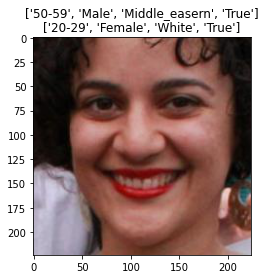

In [49]:
#loading and polotting an image that we will provide at the github repo
img = plt.imread("val/15.jpg")
plt.imshow(img)
plt.title(str(true_test_labels[15])+"\n"+str(predicted_labels[15]))

Text(0.5, 1.0, "['40-49', 'Male', 'White', 'False']\n['20-29', 'Male', 'Indian', 'False']")

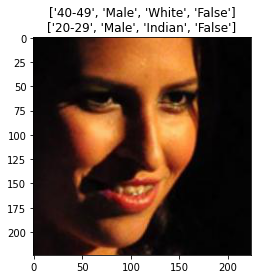

In [45]:

img = plt.imread("val/18.jpg")
plt.imshow(img)
plt.title(str(true_test_labels[18])+"\n"+str(predicted_labels[18]))

In [ ]:
predictions

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', patience=3)
#creating the neural network
def build_model(hp):
  inputs = keras.Input(shape=(train_embeddings.shape[1],))
  

  hp_activation=hp.Choice('activation', values=["relu","sigmoid"])
  x = keras.layers.Dense(units=hp.Int('units1', min_value=32, max_value=512, step=16), activation=hp.Choice('activation', values=["relu","sigmoid"]))(inputs)
  dp_rate=hp.Choice('rate1', values=[0.0,0.1,0.3,0.5,0.8])
  dp_rate2=hp.Choice('rate2', values=[0.1,0.3,0.5,0.8])
  for i in range(hp.Int('layers', 2, 6)):
    x=(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 32, 512, step=10),
                                    activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid'])))(x)
  x=tf.keras.layers.Dropout(rate=dp_rate)(x)
  #each category needs to have its own softmax activation layer 
  xs = [keras.layers.Dense(values.shape[0], activation="softmax")(x) for values in OHEC.categories_]#separate categories
  outputs = tf.keras.layers.Concatenate()(xs)

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model = keras.Model(inputs = inputs, outputs = outputs, name="OpenFace_extension")
  model.compile(
    loss=MulticatLoss(),#every bit needs to converge, maybe weighting is also needed
    optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
    metrics=["binary_accuracy"])#every bit has to be looked at separately
  return model


In [ ]:
tuner = Hyperband(
    build_model,
    objective='binary_accuracy',
    factor=10,
    max_epochs=100,
    directory='output2',
    project_name='big_homework2')

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(train_embeddings,train_labels, validation_split=0.2 ,batch_size = 32,epochs=100, callbacks=[callback])

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
plot_model(best_model, show_shapes=True, show_layer_names=True)

In [ ]:
history=best_model.fit(train_embeddings,train_labels, validation_split=0.2 ,batch_size = 32,epochs=100, callbacks=[callback])

In [ ]:
age=max(predictions[6][0:9])
age_index=list(predictions[6]).index(age)
predictions[6][age_index]=1
sex=max(predictions[6][9:11])
sex_index=list(predictions[6]).index(sex)
predictions[6][sex_index]=1
ethnicity=max(predictions[6][11:18])
ethnicity_index=list(predictions[6]).index(ethnicity)
predictions[6][ethnicity_index]=1
t_f=max(predictions[6][18:20])
t_f_index=list(predictions[6]).index(t_f)
predictions[6][t_f_index]=1

In [ ]:
round_preds=np.round(predictions[4])
x=[i for i, x in enumerate(round_preds) if x == 1]
predicted=[]
for i in range(4):
  predicted.append(label_list[x[i]])

In [ ]:
img = plt.imread("7.jpg")
plt.imshow(img)
plt.title(predicted)

In [ ]:
predicted